In [1]:
%matplotlib inline
 
import matplotlib.pyplot as plt
import numpy as np
import os
import pprint
pp = pprint.PrettyPrinter(indent=4)

In [13]:
import joblib
from skimage.io import imread
from skimage.transform import resize
 
def resize_all(src, pklname, include, width, height):
     
    data = dict()
    data['label'] = []
    data['filename'] = []
    data['data'] = []   
     
    pklname = f"{pklname}_{width}x{height}px.pkl"
 
    # read all images in PATH, resize and write to DESTINATION_PATH
    for subdir in os.listdir(src):
        if subdir in include:
            print(subdir)
            current_path = os.path.join(src, subdir)
 
            for file in os.listdir(current_path):
                if file[-3:] in {'jpg', 'png'}:
                    im = imread(os.path.join(current_path, file))
                    im = resize(im, (width, height)) #[:,:,::-1]
                    data['label'].append(subdir)
                    data['filename'].append(file)
                    data['data'].append(im)
 
        joblib.dump(data, pklname)

In [14]:
data_path = "C:\\Users\\edesm\\Desktop\\PythonProjectMusti\\classificatie"
os.listdir(data_path)

['aanwezig', 'buiten', 'niets', 'testPhoto']

In [15]:
base_name = 'kat1_niets_aanwezig'
width = 88
height = 160
 
include = {'niets', 'aanwezig'}
 
resize_all(src=data_path, pklname=base_name, width=width, height=height, include=include)

aanwezig
niets


In [16]:
from collections import Counter
 
data = joblib.load(f'{base_name}_{width}x{height}px.pkl')
 
print('number of samples: ', len(data['data']))
print('keys: ', list(data.keys()))
print('image shape: ', data['data'][0].shape)
print('labels:', np.unique(data['label']))
 
Counter(data['label'])

number of samples:  2251
keys:  ['label', 'filename', 'data']
image shape:  (88, 160, 3)
labels: ['aanwezig' 'niets']


Counter({'aanwezig': 852, 'niets': 1399})

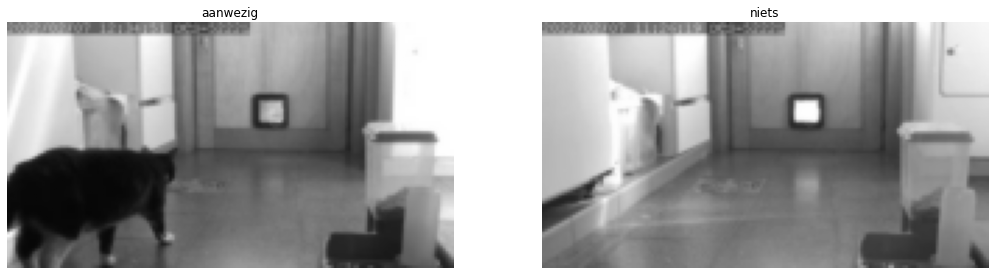

In [17]:
# use np.unique to get all unique values in the list of labels
labels = np.unique(data['label'])
 
# set up the matplotlib figure and axes, based on the number of labels
fig, axes = plt.subplots(1, len(labels))
fig.set_size_inches(15,4)
fig.tight_layout()
 
# make a plot for every label (equipment) type. The index method returns the 
# index of the first item corresponding to its search string, label in this case
for ax, label in zip(axes, labels):
    idx = data['label'].index(label)
     
    ax.imshow(data['data'][idx])
    ax.axis('off')
    ax.set_title(label)

In [18]:
X = np.array(data['data'])
y = np.array(data['label'])

In [19]:
from sklearn.model_selection import train_test_split
 
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    shuffle=True,
    random_state=42,
)

In [23]:
print(len(X))
print(len(y))
print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))

2251
2251
1800
1800
451
451


In [28]:
#data omzetten naar 2 dimensioneel ipv 4 dimensioneel
X_train = X_train.reshape(len(X_train),3*88*160)
X_test = X_test.reshape(len(X_test),3*88*160)

In [29]:
#binaire test
y_train_niets = (y_train == "niets")
y_test_niets = (y_test == "niets")

In [30]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train_niets)

SGDClassifier(random_state=42)

In [32]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_niets, cv=3, scoring="accuracy")

array([0.935     , 0.84333333, 0.835     ])

In [33]:
from sklearn.base import BaseEstimator
class NeverNietsClassifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

never_niets_clf = NeverNietsClassifier()
cross_val_score(never_niets_clf, X_train, y_train_niets, cv=3, scoring="accuracy")

array([0.37      , 0.395     , 0.35666667])

In [34]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_niets, cv=3)

In [35]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_niets, y_train_pred)

array([[ 455,  218],
       [  14, 1113]], dtype=int64)

In [36]:
y_train_perfect_predictions = y_train_niets
confusion_matrix(y_train_niets, y_train_perfect_predictions)

array([[ 673,    0],
       [   0, 1127]], dtype=int64)

In [37]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_niets, y_train_pred)

0.836213373403456

In [38]:
recall_score(y_train_niets, y_train_pred)

0.9875776397515528

In [39]:
from sklearn.metrics import f1_score

f1_score(y_train_niets, y_train_pred)

0.9056143205858421